In [1]:
sys.path.append("..")
import os
import utils
import plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import utils
import pandas as pd
import matplotlib.dates as mdates
import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

## General functions

In [2]:
def read_in_data_regions(relative_path):
    dir_path = "../"
    folder_path = dir_path + relative_path
    div_filepath = folder_path + "/div.csv"
    S_filepath = folder_path + "/S.csv" 
    I_filepath = folder_path + "/I.csv" 
    V_filepath = folder_path + "/vaccinated.csv"
    new_infected_filepath = folder_path + "/new_infected.csv" 
    new_deaths_filepath = folder_path + "/new_deaths.csv" 
    pop_age_info_filepath = folder_path + "/start_date_population_age_labels.pkl"

    start_date, population, age_labels = utils.read_pickle(pop_age_info_filepath)
    paths = utils.create_named_tuple('paths', 'filepaths.txt')
    config = utils.create_named_tuple('config', paths.config)

    div_df = pd.read_csv(div_filepath, index_col=0)
    S_df = pd.read_csv(S_filepath, index_col=0)
    I_df = pd.read_csv(I_filepath, index_col=0)
    new_infected_df = pd.read_csv(new_infected_filepath, index_col=0)
    new_deaths_df = pd.read_csv(new_deaths_filepath, index_col=0)
    V_df = pd.read_csv(V_filepath, index_col=0)

    nr_simulations = div_df.loc[len(div_df)-1].simulation_nr
    nr_weeks = div_df.loc[len(div_df)-1].week_nr
    nr_regions = len(population)

    S_regions = np.zeros((nr_simulations, nr_weeks, nr_regions))
    I_regions = np.zeros((nr_simulations, nr_weeks, nr_regions))
    V_regions = np.zeros((nr_simulations, nr_weeks, nr_regions))
    new_infected_regions = np.zeros((nr_simulations, nr_weeks, nr_regions))
    new_deaths_regions = np.zeros((nr_simulations, nr_weeks, nr_regions))

    for i in tqdm(range(nr_simulations)):
        S_regions[i, :, :] = S_df.loc[(i)*75:(i+1)*75 - 1].to_numpy()[:,3:-7]
        I_regions[i, :, :] = I_df.loc[(i)*75:(i+1)*75 - 1].to_numpy()[:,3:-7]
        V_regions[i, :, :] = V_df.loc[(i)*75:(i+1)*75 - 1].to_numpy()[:,3:-7]
        new_infected_regions[i, :, :] = new_infected_df.loc[(i)*75:(i+1)*75 - 1].to_numpy()[:,3:-7]
        new_deaths_regions[i, :, :] = new_deaths_df.loc[(i)*75:(i+1)*75 - 1].to_numpy()[:,3:-7]

    return S_regions, I_regions, V_regions, new_infected_regions, new_deaths_regions


In [3]:
def read_in_data_agegroups(relative_path):
    """ Read in data from agegroups
    """
    dir_path = "../"
    folder_path = dir_path + relative_path
    div_filepath = folder_path + "/div.csv"
    S_filepath = folder_path + "/S.csv" 
    I_filepath = folder_path + "/I.csv" 
    new_infected_filepath = folder_path + "/new_infected.csv" 
    new_deaths_filepath = folder_path + "/new_deaths.csv" 
    V_filepath = folder_path + "/vaccinated.csv"
    pop_age_info_filepath = folder_path + "/start_date_population_age_labels.pkl"

    start_date, population, age_labels = utils.read_pickle(pop_age_info_filepath)
    paths = utils.create_named_tuple('paths', 'filepaths.txt')
    config = utils.create_named_tuple('config', paths.config)

    div_df = pd.read_csv(div_filepath, index_col=0)
    S_df = pd.read_csv(S_filepath, index_col=0)
    I_df = pd.read_csv(I_filepath, index_col=0)
    V_df = pd.read_csv(V_filepath, index_col=0)
    new_infected_df = pd.read_csv(new_infected_filepath, index_col=0)
    new_deaths_df = pd.read_csv(new_deaths_filepath, index_col=0)

    nr_simulations = div_df.loc[len(div_df)-1].simulation_nr
    nr_weeks = div_df.loc[len(div_df)-1].week_nr
    nr_regions = len(population)
    nr_age_groups = len(age_labels)

    S_age_groups = np.zeros((nr_simulations, nr_weeks, nr_age_groups))
    I_age_groups = np.zeros((nr_simulations, nr_weeks, nr_age_groups))
    V_age_groups = np.zeros((nr_simulations, nr_weeks, nr_age_groups))
    new_infected_age_groups = np.zeros((nr_simulations, nr_weeks, nr_age_groups))
    new_deaths_age_groups = np.zeros((nr_simulations, nr_weeks, nr_age_groups))

    for i in tqdm(range(nr_simulations)):
        S_age_groups[i, :, :] = S_df.loc[(i)*75:(i+1)*75 - 1].to_numpy()[:,-7:]
        I_age_groups[i, :, :] = I_df.loc[(i)*75:(i+1)*75 - 1].to_numpy()[:,-7:]
        V_age_groups[i, :, :] = V_df.loc[(i)*75:(i+1)*75 - 1].to_numpy()[:,-7:]
        new_infected_age_groups[i, :, :] = new_infected_df.loc[(i)*75:(i+1)*75 - 1].to_numpy()[:,-7:]
        new_deaths_age_groups[i, :, :] = new_deaths_df.loc[(i)*75:(i+1)*75 - 1].to_numpy()[:,-7:]
    
    S_df['date'] = pd.to_datetime(S_df['date'], format='%Y-%m-%d')
    dates = S_df['date'].iloc[:nr_weeks]

    
    return S_age_groups, I_age_groups, V_age_groups, new_infected_age_groups, new_deaths_age_groups, dates

In [4]:
def prepare_regional_data(data):
    m,n,r = data.shape
    out_arr = np.column_stack((np.repeat(np.arange(m),n),data.reshape(m*n,-1)))
    out_df = pd.DataFrame(out_arr)
    out_df['week'] = out_df.index % data.shape[1]
    out_df = out_df.rename(columns={0:'simulation'})
    out_df['simulation'] = out_df['simulation'].astype(int)
    out_df.set_index(['simulation', 'week'], inplace=True)
    return out_df

# Spatial Plotting

## Prepare data

In [5]:
# Read data and generate parameters
paths = utils.create_named_tuple('paths', 'filepaths.txt')
config = utils.create_named_tuple('config', paths.config)
age_labels = utils.generate_labels_from_bins(config.age_bins)
population = utils.generate_custom_population(config.age_bins, age_labels)

In [6]:
# generate geodatefram for plotting
gdf = utils.generate_geopandas(population, paths.municipalities_geo)

In [7]:
# Vaccines - Susceptible policy
S_regions_inf, I_regions_inf, V_regions_inf, new_infected_regions_inf, new_deaths_regions_inf = read_in_data_regions('results/5_simulations_infection_based_2021_06_02_13_44_25')
X = np.insert(np.diff(V_regions_inf, axis=1), 0, 0, axis=1) # Need to this on vaccines since the first week is deleted when taking the difference of V for each week
df_x_regions_inf = prepare_regional_data(X)

100%|██████████| 5/5 [00:00<00:00, 74.23it/s]


In [8]:
# Vaccines - Infected policy
S_regions_sus, I_regions_sus, V_regions_sus, new_infected_regions_sus, new_deaths_regions_sus = read_in_data_regions('results/5_simulations_susceptible_based_2021_06_02_13_42_31')
X = np.insert(np.diff(V_regions_sus, axis=1), 0, 0, axis=1)
df_x_regions_sus = prepare_regional_data(X)

100%|██████████| 5/5 [00:00<00:00, 121.94it/s]


In [9]:
# Infected
df_I_regions = prepare_regional_data(I_regions_inf)

In [10]:
data = {'Infected-policy': df_x_regions_inf, 'Susceptible-policy': df_x_regions_sus, 'Symptomatic-Infected': df_I_regions}

## Plot

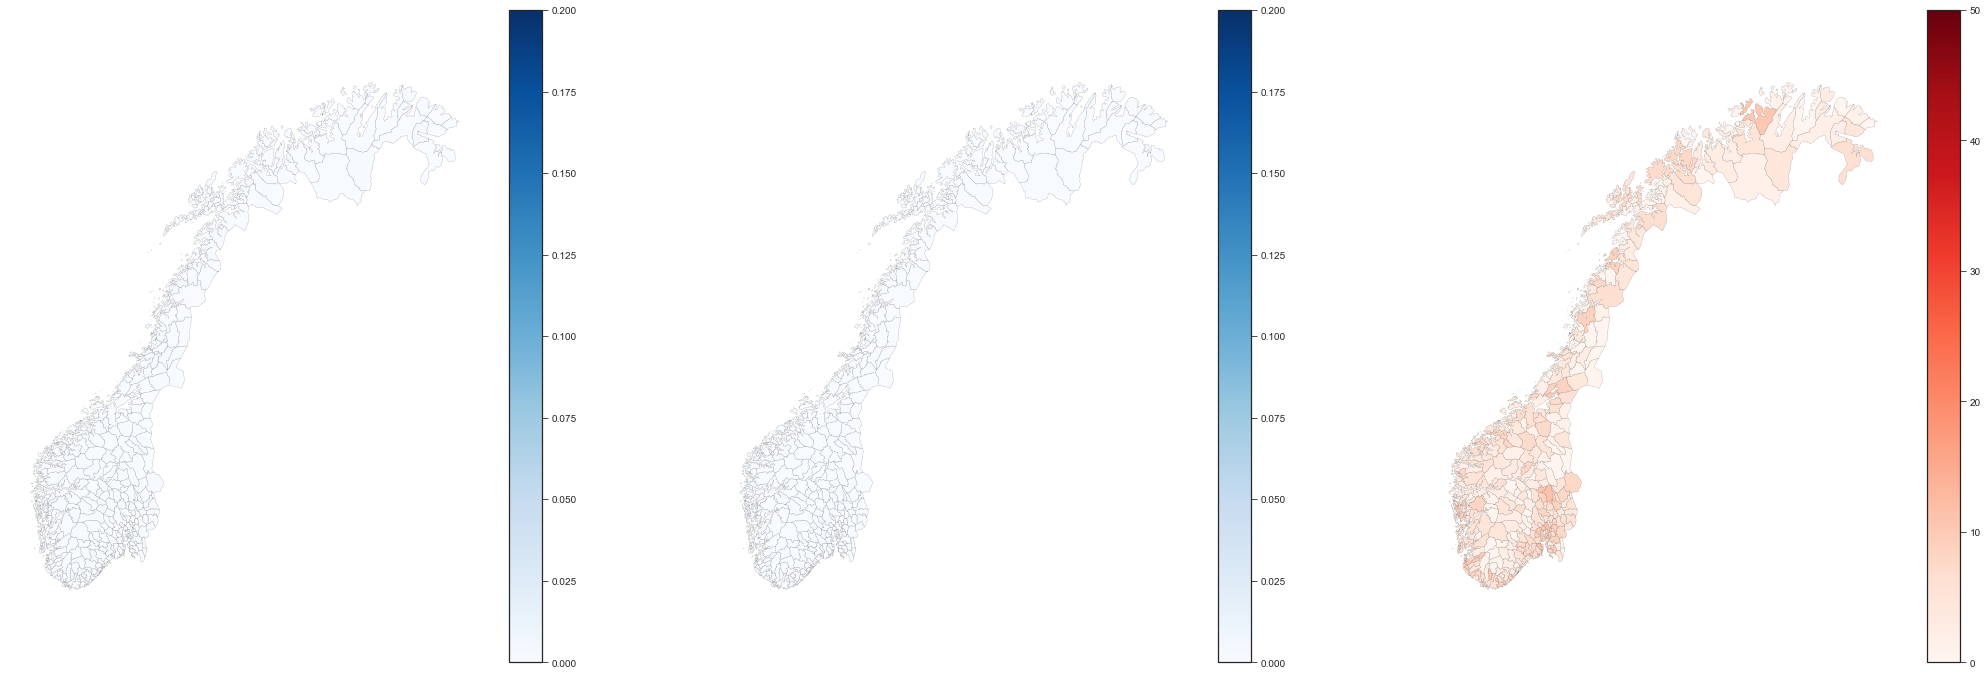

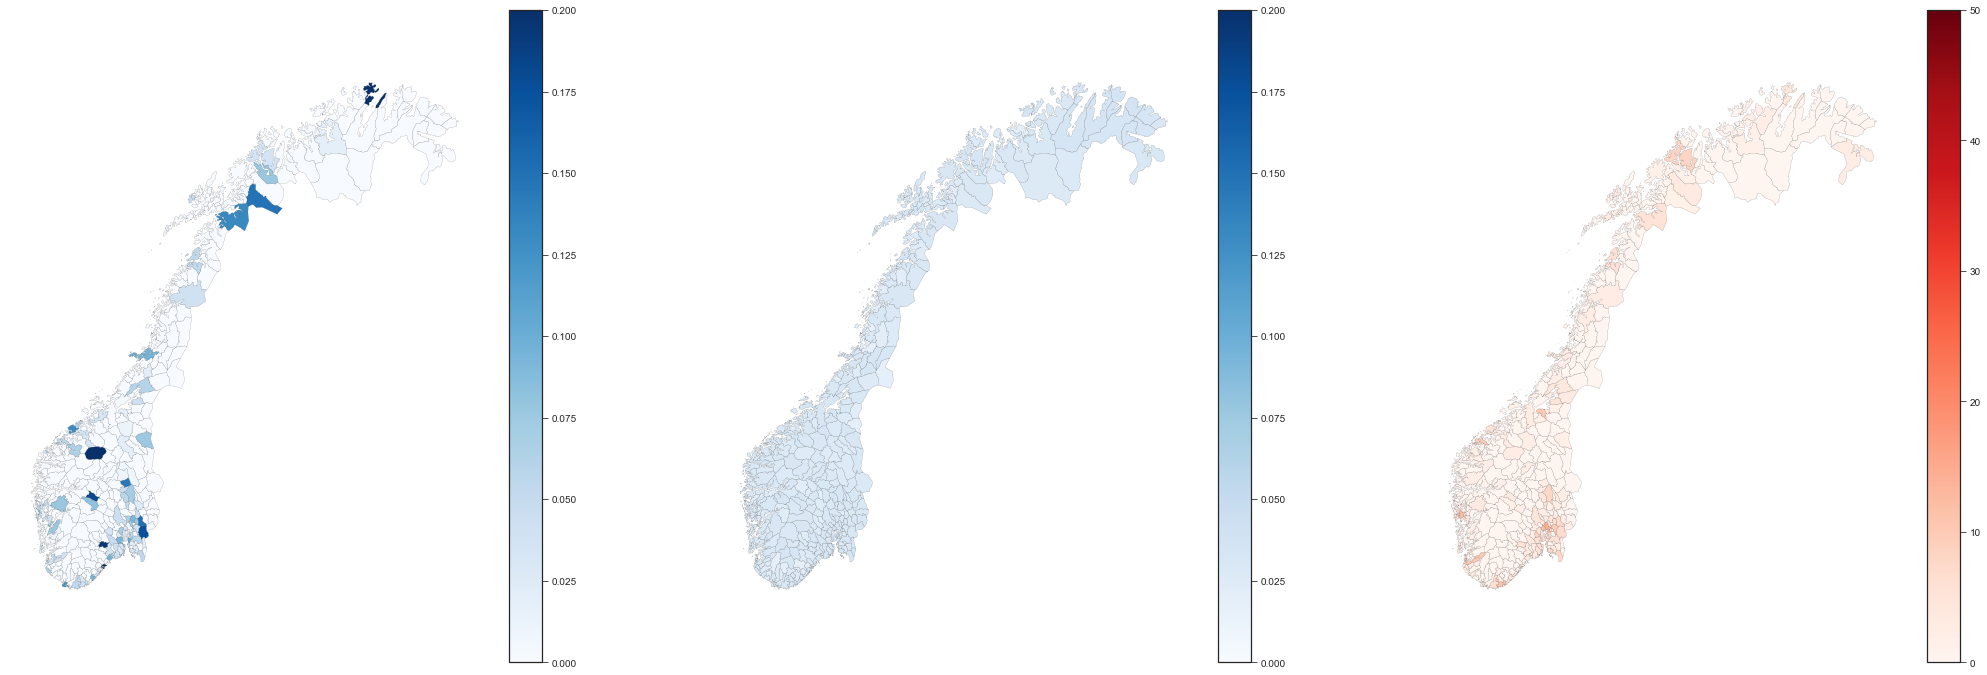

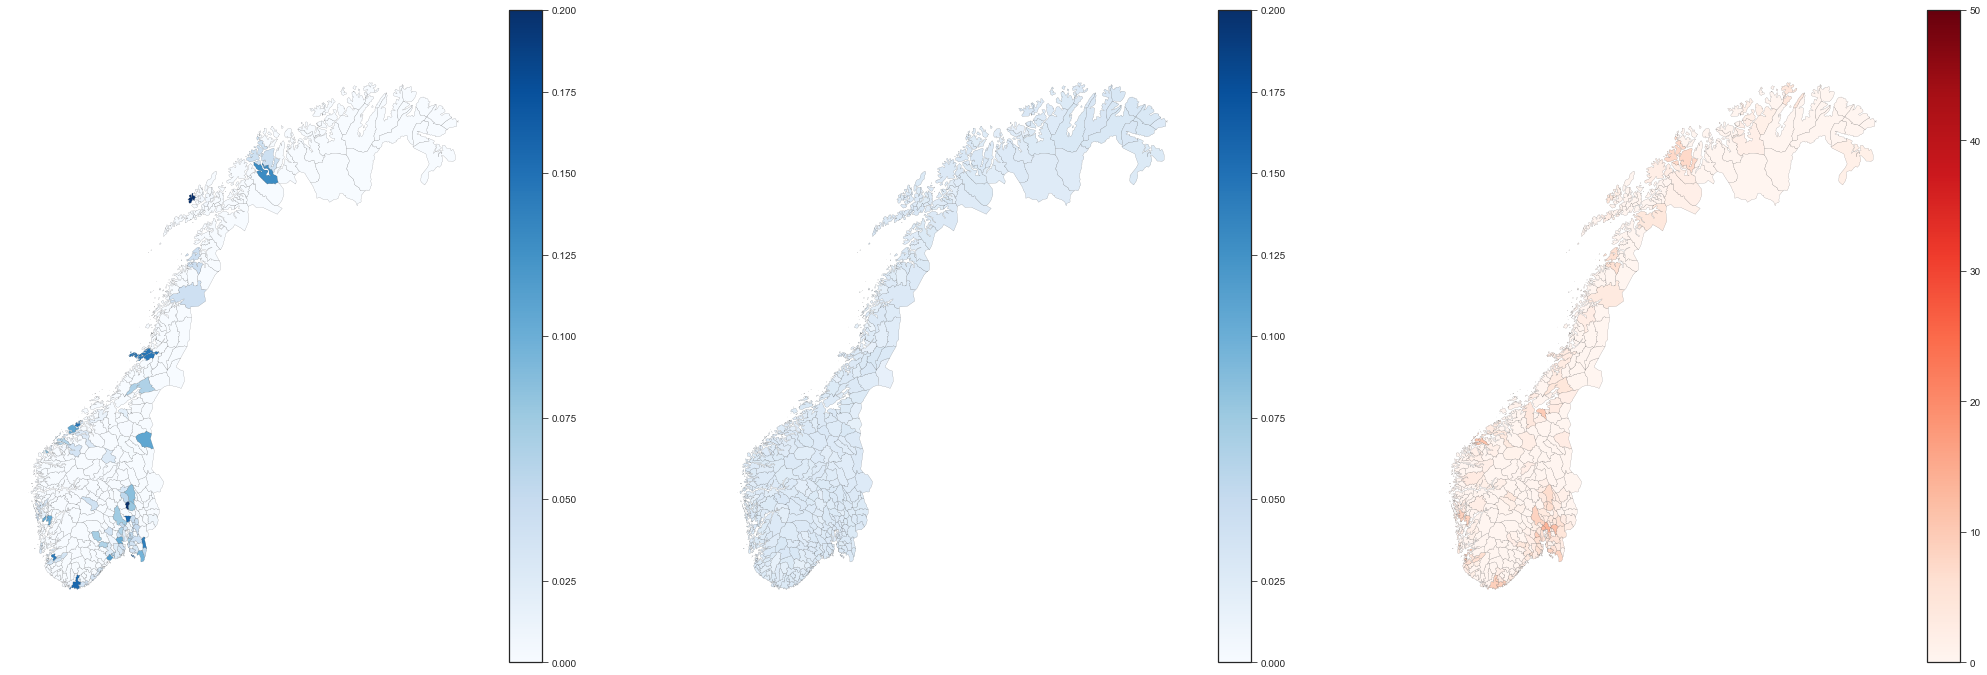

In [24]:
plt.style.use('seaborn-ticks')
simulations = [0] # simulation starts at 0
weeks = [45, 70, 72] # weeks starts at 1
policies = list(data.keys())
max_images_on_one_row = 2
nrows=1
ncols=3

for sim in simulations:
    for week in weeks:
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12*ncols,12*nrows), sharex=True)
        col = 0 
        for i, value in enumerate(policies):
            x = data[value].loc[(sim,week)]
            x.index -= 1
            gdf[value] = x
            ax = axs[col]
            if value == 'Symptomatic-Infected':
                gdf.plot(ax=ax, column=value, facecolor='white', edgecolor='black', alpha=1, linewidth=0.1, zorder=2, cmap='Reds', legend=True, vmin=0,vmax=50)
            else:
                gdf[value+'_percentage'] = gdf[value]/gdf['population']
                gdf.plot(ax=ax, column=value+'_percentage', facecolor='white', edgecolor='black', alpha=1, linewidth=0.1, zorder=2, cmap='Blues', legend=True, vmin=0,vmax=0.2)
            ax.axis('off')
            col += 1
        plt.draw()
        plt.savefig(f"../plots/computational_study/regional_development/sim_{sim}_week_{week}.jpg", dpi=fig.dpi, bbox_inches = 'tight')

# Historical Plotting

## Prepare Data

In [12]:
# Load data
S_age_groups, I_age_groups, V_age_groups, new_infected_age_groups, new_deaths_age_groups, dates = read_in_data_agegroups('results/5_simulations_susceptible_based_2021_06_02_13_42_31')
df = pd.read_csv('../data/waves/world_daily_cases.csv')
df = df[df.country == "Norway"].fillna(0)

100%|██████████| 5/5 [00:00<00:00, 205.38it/s]


In [13]:
# Calculate percentiles
percentile_limit=90

new_deaths_all_age_groups = np.sum(new_deaths_age_groups, axis=2)
new_infected_all_age_groups =  np.sum(new_infected_age_groups, axis=2)


deaths_cumulative = new_deaths_all_age_groups.cumsum(axis=1)
deaths_mean = new_deaths_all_age_groups.mean(axis=0)
deaths_mean_cumulative = deaths_cumulative.mean(axis=0)
u_percentile_deaths = np.percentile(new_deaths_all_age_groups, percentile_limit, axis=0)
l_percentile_deaths = np.percentile(new_deaths_all_age_groups, 100-percentile_limit, axis=0)
u_percentile_deaths_cum = np.percentile(deaths_cumulative, percentile_limit, axis=0)
l_percentile_deaths_cum = np.percentile(deaths_cumulative, 100-percentile_limit, axis=0)

infected_cumulative = new_infected_all_age_groups.cumsum(axis=1)
infected_mean = new_infected_all_age_groups.mean(axis=0)
infected_mean_cumulative = infected_cumulative.mean(axis=0)
u_percentile_infected = np.percentile(new_infected_all_age_groups, percentile_limit, axis=0)
l_percentile_infected = np.percentile(new_infected_all_age_groups, 100-percentile_limit, axis=0)
u_percentile_infected_cum = np.percentile(infected_cumulative, percentile_limit, axis=0)
l_percentile_infected_cum = np.percentile(infected_cumulative, 100-percentile_limit, axis=0)

## Plot cases

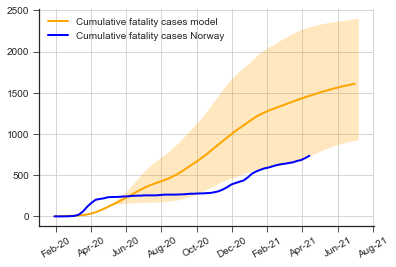

In [14]:
plt.style.use('seaborn-ticks')
restrict_to_real_data_length = False
max_weeks_real_data = 63

fig, ax = plt.subplots(1)

if restrict_to_real_data_length:
    ax.plot(dates[:max_weeks_real_data], deaths_mean_cumulative[:max_weeks_real_data], lw=2, label='Cumulative fatality cases model', color='orange')
    ax.plot(dates[:max_weeks_real_data], df.cumulative_total_deaths.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative fatality cases Norway', color='blue')
    ax.fill_between(dates[:max_weeks_real_data], u_percentile_deaths_cum[:max_weeks_real_data], l_percentile_deaths_cum[:max_weeks_real_data], facecolor='orange', alpha=0.25)

else:
    ax.plot(dates[:-1], deaths_mean_cumulative[:-1], lw=2, label='Cumulative fatality cases model', color='orange')
    ax.plot(dates[:max_weeks_real_data], df.cumulative_total_deaths.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative fatality cases Norway', color='blue')
    ax.fill_between(dates, u_percentile_deaths_cum, l_percentile_deaths_cum, facecolor='orange', alpha=0.25)

ax.legend(loc='upper left')

# Format the date into months & days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) 
# Change the tick interval
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60)) 
# Puts x-axis labels on an angle
plt.gca().xaxis.set_tick_params(rotation =30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid()
fig.savefig("../plots/computational_study/deaths_comparison.png", bbox_inches='tight', dpi=150)

## Plot deaths

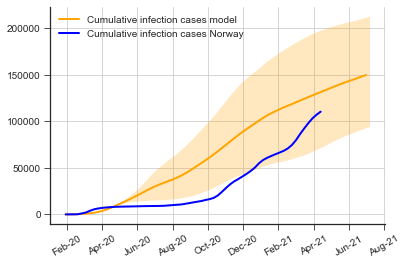

In [15]:
plt.style.use('seaborn-ticks')
restrict_to_real_data_length = False
max_weeks_real_data = 63

fig, ax = plt.subplots(1)
#ax.plot(dates, deaths_mean, lw=2, label='Deaths model', color='blue')
if restrict_to_real_data_length:
    ax.plot(dates[:max_weeks_real_data], infected_mean_cumulative[:max_weeks_real_data], lw=2, label='Cumulative infection cases model', color='orange')
    ax.plot(dates[:max_weeks_real_data], df.cumulative_total_cases.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative infection cases Norway', color='blue')
    ax.fill_between(dates[:max_weeks_real_data], u_percentile_infected_cum[:max_weeks_real_data], l_percentile_infected_cum[:max_weeks_real_data], facecolor='orange', alpha=0.25)
else:
    ax.plot(dates[:-1], infected_mean_cumulative[:-1], lw=2, label='Cumulative infection cases model', color='orange')
    ax.plot(dates[:max_weeks_real_data], df.cumulative_total_cases.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative infection cases Norway', color='blue')
    #ax.fill_between(dates, u_percentile_deaths, l_percentile_deaths, facecolor='blue', alpha=0.25)
    ax.fill_between(dates, u_percentile_infected_cum, l_percentile_infected_cum, facecolor='orange', alpha=0.25)

#ax.set_title(r'Cumulative and new infected per week')
ax.legend(loc='upper left')

# Format the date into months & days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) 
# Change the tick interval
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60)) 
# Puts x-axis labels on an angle
plt.gca().xaxis.set_tick_params(rotation =30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid()


fig.savefig("../plots/computational_study/infected_comparison.png", bbox_inches='tight', dpi=150)